In [2]:
import os
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

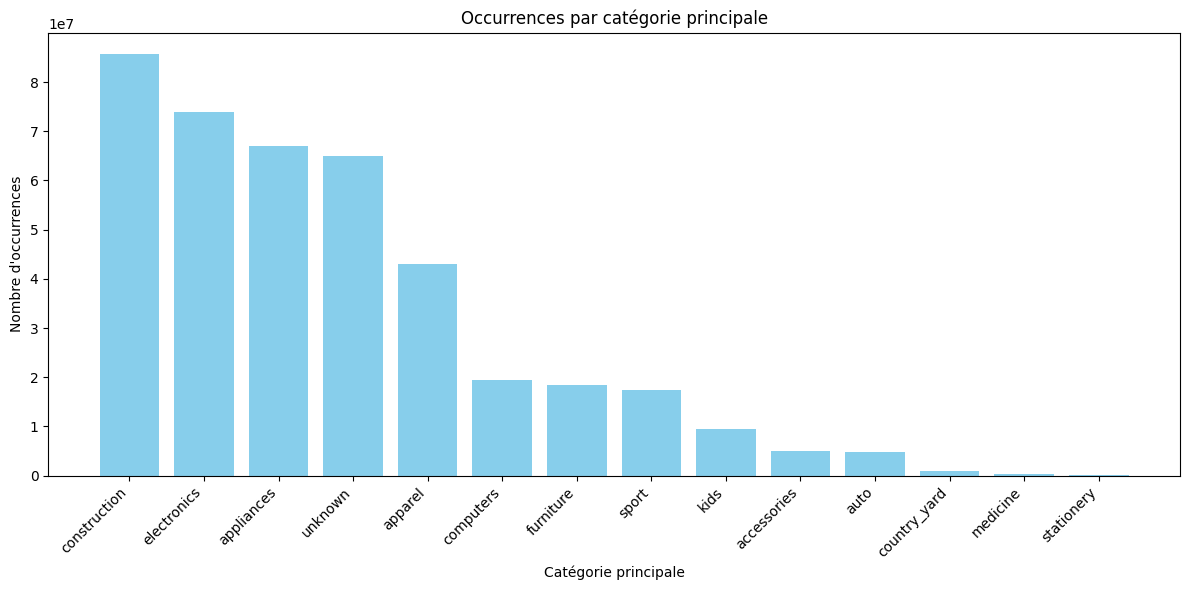

In [8]:
# Charger le fichier des catégories scindées
input_file = "../data/output/category_counts_split.csv"
df = pd.read_csv(input_file)

# Regrouper les données par catégorie principale
category_summary = df.groupby("main_category")["count"].sum().reset_index()
category_summary = category_summary.sort_values(by="count", ascending=False)

# Affichage du graphique
plt.figure(figsize=(12, 6))
plt.bar(category_summary["main_category"], category_summary["count"], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Catégorie principale")
plt.ylabel("Nombre d'occurrences")
plt.title("Occurrences par catégorie principale")
plt.tight_layout()

plt.show()

In [11]:
# Dossier contenant les fichiers nettoyés
cleaned_dir = "../data/cleaned/"

# Liste des fichiers Parquet à analyser
parquet_files = [f for f in os.listdir(cleaned_dir) if f.endswith(".parquet")]

# Catégories principales sélectionnées
selected_categories = ["electronics", "computers", "sport", "kids"]

# Dictionnaires pour stocker les données
sales_data = []
view_data = []

# Exploration des fichiers
for file in parquet_files:
    parquet_path = os.path.join(cleaned_dir, file)
    print(f"🔍 Exploration de {file}...")

    # Lire le fichier par batch pour éviter les MemoryError
    parquet_file = pq.ParquetFile(parquet_path)
    batch_size = 500_000  

    for batch in parquet_file.iter_batches(batch_size=batch_size):
        chunk = batch.to_pandas()[["event_time", "event_type", "category_code"]].dropna()
        
        # Extraire uniquement la catégorie principale
        chunk["main_category"] = chunk["category_code"].str.split(".").str[0]

        # Filtrer les catégories sélectionnées
        chunk = chunk[chunk["main_category"].isin(selected_categories)]

        # Filtrer les achats et les vues
        purchases = chunk[chunk["event_type"] == "purchase"]
        views = chunk[chunk["event_type"] == "view"]

        # Agréger par date et catégorie principale
        sales_agg = purchases.groupby([purchases["event_time"].str[:10], "main_category"]).size().reset_index(name="sales_count")
        views_agg = views.groupby([views["event_time"].str[:10], "main_category"]).size().reset_index(name="views_count")

        sales_data.append(sales_agg)
        view_data.append(views_agg)

# Fusionner toutes les données
df_sales = pd.concat(sales_data, ignore_index=True)
df_views = pd.concat(view_data, ignore_index=True)

# Joindre les ventes et les vues pour calculer le taux de transformation
df_merged = pd.merge(df_sales, df_views, on=["event_time", "main_category"], how="left").fillna(0)
df_merged["conversion_rate"] = df_merged["sales_count"] / df_merged["views_count"]
df_merged["conversion_rate"].fillna(0, inplace=True)  # Éviter les NaN en cas de division par zéro

# Sauvegarde des résultats
df_merged.to_csv("../data/output/sales_conversion_selected_categories.csv", index=False)

print("\n✅ Analyse terminée ! Résultats sauvegardés dans '../data/output/sales_conversion_selected_categories.csv'.")


🔍 Exploration de 2019-Dec.parquet...
🔍 Exploration de 2019-Nov.parquet...
🔍 Exploration de 2019-Oct.parquet...
🔍 Exploration de 2020-Apr.parquet...
🔍 Exploration de 2020-Feb.parquet...
🔍 Exploration de 2020-Jan.parquet...
🔍 Exploration de 2020-Mar.parquet...

✅ Analyse terminée ! Résultats sauvegardés dans '../data/output/sales_conversion_selected_categories.csv'.


C:\Users\Pierre\AppData\Local\Temp\ipykernel_9336\2757300381.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged["conversion_rate"].fillna(0, inplace=True)  # Éviter les NaN en cas de division par zéro


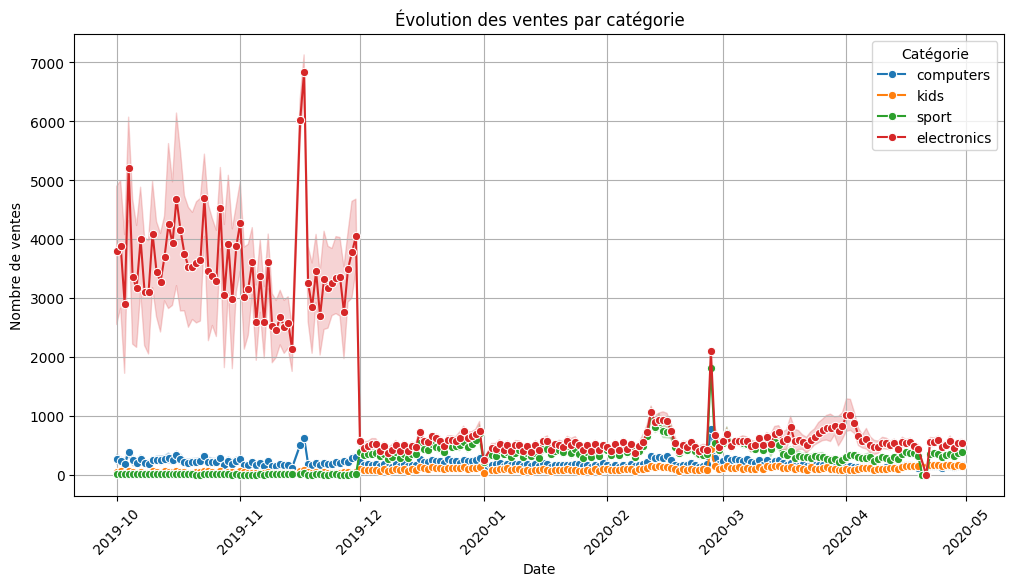

In [3]:
# Charger les données
file_path = "../data/output/sales_conversion_selected_categories.csv"
df = pd.read_csv(file_path)

# Convertir event_time en datetime
df["event_time"] = pd.to_datetime(df["event_time"])

# Trier par date
df = df.sort_values("event_time")

# Création du graphique
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="event_time", y="sales_count", hue="main_category", marker="o")

# Mise en forme
plt.xlabel("Date")
plt.ylabel("Nombre de ventes")
plt.title("Évolution des ventes par catégorie")
plt.xticks(rotation=45)
plt.legend(title="Catégorie")
plt.grid(True)

# Affichage du graphique
plt.show()
